回顾一个经典注意力框架，解释如何在视觉场景中展开注意力。 受此框架中的注意力提示（attention cues）的启发， 我们将设计能够利用这些注意力提示的模型。
1964年的Nadaraya-Waston核回归（kernel regression）正是具有 注意力机制（attention mechanism）的机器学习的简单演示。

1. 注意力可分为**自主性**的与**非自主性**的注意力。
2. 卷积、全连接、池化层都只考虑**非自主性**的线索(Nonvolitional cues)，比如初级的图像特征。
3. 注意力机制则显式地考虑**自主性**的线索(Volitional cues)，这也是注意力机制与全连接层/汇聚层的不同之处。
    - **自主性**的线索被称为查询（query）
    - 每个输入是一个值(value)和**非自主**线索(key)的对
    - query (自主性线索)和 key (非自主性线索)在经过注意力汇聚层后，选择最匹配的 value
    - 注意力汇聚**有选择地聚合**了值（感官输入）以生成最终的输出。


## 非参注意力池化层
- 给定 k-v 对的数据集$(x_i,y_i),i=1,\dots,n$
- 平均池化是最简单的方案：$f(x) = \frac{1}{n} \sum_i y_i$
- 更好的方案是60年代的 _Nadaraya-Watson_ 核回归，是一种**非参**的方案，不需要学习任何东西。实质有点像 KNN 算法。



In [17]:
# 该知识点不是很重要，随便看看
import torch
from torch import nn
from d2l import torch as d2l


### 可视化函数
为了可视化注意力权重，需要定义一个show_heatmaps函数。 其输入matrices的形状是 （要显示的行数，要显示的列数，查询的数目，键的数目）。

In [18]:
#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),cmap='Reds'):
    """显示矩阵热图"""
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

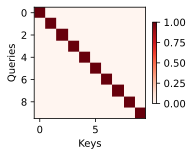

In [19]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

## 回归问题：给出一堆数据，怎样拟合函数？
### 1. 生成数据集

In [20]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的值域[0,5]的训练样本

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出

x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出

n_test = len(x_test)  # 测试样本数
n_test

50

本函数用来绘制所有的训练样本、不带噪声项的真实数据生成函数（标记为“Truth”）、以及学习得到的预测函数（标记为“Pred”）。

In [21]:
def plot_kernel_reg(y_hat):
    # 绘制真实函数和预测函数
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])

    # 绘制训练样本
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

## 2.平均汇聚
$$ f(x) = \frac{1}{n} \sum_{i=1}^n y_i$$
回归效果很差，因为只考虑输出 $y_i$ ,忽略了输入$x_i$

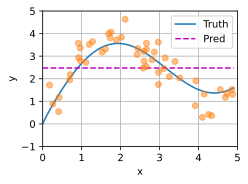

In [22]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test) # repeat_interleave() 生成值为y_train.mean()的 n_test 个重复元素
plot_kernel_reg(y_hat)

## 3.非参数注意力汇聚 Nadaraya - Watson 核回归
具体实现并不重要，重要的是明白
1. $x_i$ 对回归很重要。
2. $x$ 就是我们提供的 query
3. $(x_i,y_i)$是 K-V 对

### 核心含义：如果一个键 $x_i$ 越是接近给定的查询 $x$ ，那么分配给这个 $x_i$ 对应 $y_i$ 的注意力权重就会越大，也就“获得了更多的注意力”。
另外，Nadaraya - Watson 核回归只是像 KNN 算法一样，对数据本身进行某种统计，不需要额外的控制参数。因此称为 *非参数的注意力汇聚* 模型

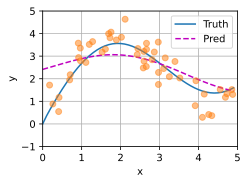

In [23]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))

# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)

# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

发现新的模型预测线是平滑的，并且比平均汇聚的预测更接近真实。

测试数据的输入相当于查询，而训练数据的输入相当于键。
因为两个输入都是经过排序的，因此可知 query 与 key 越接近， 注意力汇聚的注意力权重就越高。

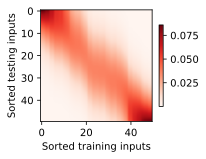

In [24]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

## 4. 带参数注意力汇聚
并在此基础上引入可以学习参数 $w$:
    $$f(x) = \sum_{i=1}^n softmax(-\frac{1}{2}((x-x_i)\textcolor{red}{w})^2)y_i$$

### (1) 批量矩阵乘法

In [25]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))

# 按照X和Y的第一个维度，对剩余维度进行矩阵乘法
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

### (2) 定义模型

In [26]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True)) # Parameter() 标记可训练参数并自动梯度计算。(1,)表示是一个 tuple 而非标量

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

### (3) 训练
将训练数据集变换为 key 和 value 用于训练注意力模型。 在带参数的注意力汇聚模型中， 任何一个训练样本的输入都会和除自己以外的所有训练样本的“键－值”对进行计算， 从而得到其对应的预测输出。

In [27]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1)) # 把 1*n_train 的 tensor 再复制 n_train 次，shape 变成 n_train*n_train
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))

# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
X_tile.shape,Y_tile.shape,keys.shape,values.shape

(torch.Size([50, 50]),
 torch.Size([50, 50]),
 torch.Size([50, 49]),
 torch.Size([50, 49]))

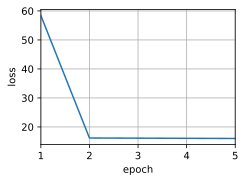

In [28]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

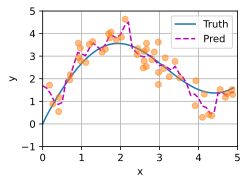

In [29]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

新的模型更不平滑了,这是因为带参数的模型加入可学习的参数后， 曲线在注意力权重较大的区域变得更不平滑。

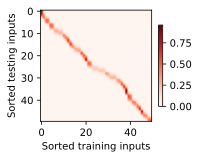

In [30]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')